In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'mma-facial-expression:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F696331%2F1218456%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240322%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240322T135245Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0e76376f01fedadb5252148e424fedb7459d954d24a1a6537c384cd8c964754f0960028f103973e2ee04804c8ab2f430acfd8f1e97140483e8da498572f285093a1d791f1e926d445e1aa01cbbb682acf5f252367ab3217c1e2d8c641652ee06b0e7cae83dac241ed5af2facb3855f257496635d291215c741f4f0a9b888abe235ea336ef4f9f0a156573c3c9ae2b1bb178b16230de7b68c30d0d79d39d49ced2a7e0d30d4669d71263410458cc1e35df08956d16c06ba403756c2ffaa41052e8bfa25b7f0b336a2f43ee48ba9c78015eb253db47e9187dc806edd394bce1cb38d1366bee3deae5d8ee06f4b12612e8c12ed378c97852c9e02291e8c663bac63'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 173545522 bytes downloaded
Downloaded and uncompressed: mma-facial-expression
Data source import complete.


In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
train_dir = "/kaggle/input/mma-facial-expression/MMAFEDB/train"
test_dir = "/kaggle/input/mma-facial-expression/MMAFEDB/test"
val_dir = "/kaggle/input/mma-facial-expression/MMAFEDB/valid"

data = {"images":[], "labels":[]}
for i in [train_dir, test_dir, val_dir]:
  for j in os.listdir(i):
    dir_1 = os.path.join(i, j)
    for k in os.listdir(dir_1):
      dir_2 = os.path.join(dir_1, k)
      data["images"].append(dir_2)
      data["labels"].append(j)

df = pd.DataFrame(data)

print(df.shape)

df.head()


(127680, 2)


images labels
0  /kaggle/input/mma-facial-expression/MMAFEDB/tr...  angry
1  /kaggle/input/mma-facial-expression/MMAFEDB/tr...  angry
2  /kaggle/input/mma-facial-expression/MMAFEDB/tr...  angry
3  /kaggle/input/mma-facial-expression/MMAFEDB/tr...  angry
4  /kaggle/input/mma-facial-expression/MMAFEDB/tr...  angry

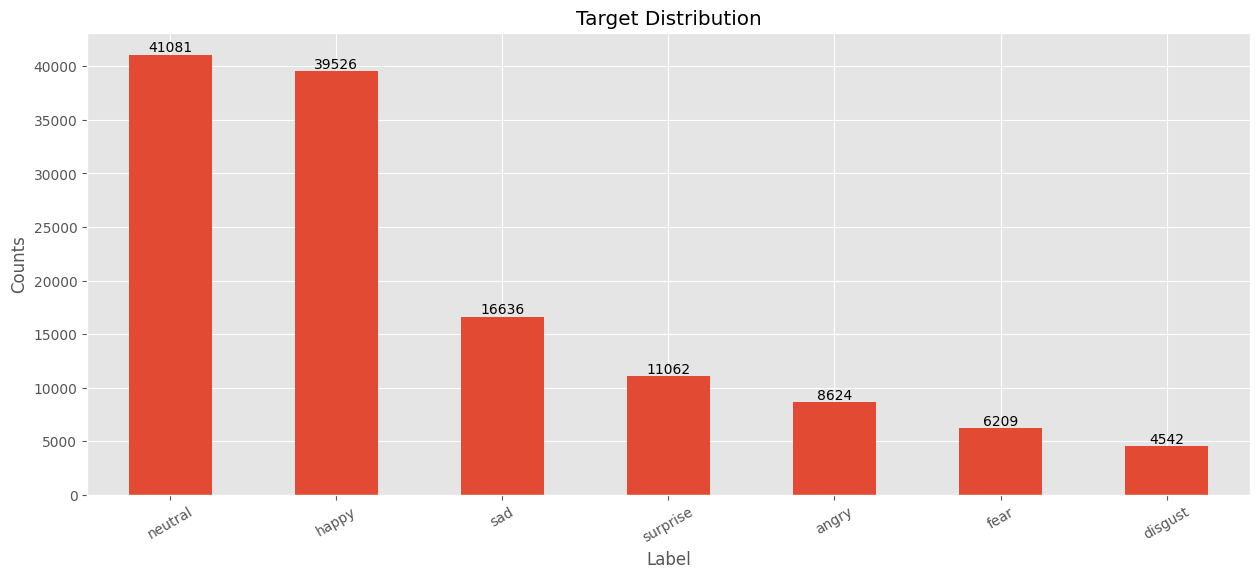

In [4]:
plt.style.use("ggplot")

plt.figure(figsize=(15, 6))

barplot = df["labels"].value_counts().plot(kind="bar")

for p in barplot.patches:
  h = p.get_height()
  barplot.text(p.get_x()+(p.get_width()/2), h, f"{h:}", va="bottom", ha="center")

barplot.set_xlabel("Label")
barplot.set_ylabel("Counts")
barplot.set_title("Target Distribution")
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=30)
plt.show()


## Observation:
* Imbalance Dataset

In [5]:
dwn_samp = RandomUnderSampler()

dwn_smp_X, dwn_smp_y = dwn_samp.fit_resample(pd.DataFrame(df["images"]), pd.DataFrame(df["labels"]))

In [6]:
dwn_samp_data = pd.concat([dwn_smp_X, dwn_smp_y], axis="columns")

print(dwn_samp_data.shape)

(31794, 2)


In [7]:
dwn_samp_data["labels"].value_counts()

angry       4542
disgust     4542
fear        4542
happy       4542
neutral     4542
sad         4542
surprise    4542
Name: labels, dtype: int64

In [9]:
from transformers import ViTFeatureExtractor

transformer_prep = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [10]:
train_gen = keras.preprocessing.image.ImageDataGenerator(
                                                          preprocessing_function = lambda x: transformer_prep.preprocess(x, data_format="channels_last", )["pixel_values"][0],
                                                          # rotation_range=15,
                                                          # zoom_range=0.15,
                                                          # #rescale = 1/255,
                                                          # #width_shift_range=0.2,
                                                          # brightness_range=(.6, 1.2),
                                                          # shear_range=.15,
                                                          # #height_shift_range=0.2,
                                                          # horizontal_flip=True,
                                                          # fill_mode="nearest"
                                                          )

test_gen = keras.preprocessing.image.ImageDataGenerator(
          preprocessing_function=lambda x: transformer_prep.preprocess(x, data_format="channels_last")["pixel_values"][0]
           #preprocessing_function=vgg16.preprocess_input
          )

In [11]:
Xtrain, Xtest, ytrain, ytest = train_test_split(dwn_samp_data["images"], dwn_samp_data["labels"], test_size=0.2, stratify=dwn_samp_data["labels"])

Xtest, Xval, ytest, yval = train_test_split(Xtest, ytest, test_size=0.1, stratify=ytest)

print(Xtrain.shape, Xtest.shape, Xval.shape)

(25435,) (5723,) (636,)


In [12]:
train = pd.concat([Xtrain, ytrain], axis="columns")
test = pd.concat([Xtest, ytest], axis="columns")
val = pd.concat([Xval, yval], axis="columns")

In [13]:
train_data_gen = train_gen.flow_from_dataframe(dataframe=train,
                                               x_col="images",
                                               y_col="labels",
                                               target_size=(224, 224),
                                               color_mode="rgb")

test_data_gen = test_gen.flow_from_dataframe(dataframe=test,
                                             x_col="images",
                                             y_col="labels",
                                             target_size=(224, 224),
                                             color_mode="rgb")

val_data_gen = test_gen.flow_from_dataframe(dataframe=val,
                                            x_col="images",
                                            y_col="labels",
                                            target_size=(224, 224),
                                            color_mode="rgb")

Found 25435 validated image filenames belonging to 7 classes.
Found 5723 validated image filenames belonging to 7 classes.
Found 636 validated image filenames belonging to 7 classes.


In [14]:
train_data_gen[0][0][0]

array([[[ 0.92156863,  0.99215686,  0.9529412 ],
        [ 0.92156863,  0.99215686,  0.9529412 ],
        [ 0.92156863,  0.99215686,  0.9529412 ],
        ...,
        [ 0.13725495,  0.05098045,  0.00392163],
        [ 0.13725495,  0.05098045,  0.00392163],
        [ 0.13725495,  0.05098045,  0.00392163]],

       [[ 0.92156863,  0.99215686,  0.9529412 ],
        [ 0.92156863,  0.99215686,  0.9529412 ],
        [ 0.92156863,  0.99215686,  0.9529412 ],
        ...,
        [ 0.13725495,  0.05098045,  0.00392163],
        [ 0.13725495,  0.05098045,  0.00392163],
        [ 0.13725495,  0.05098045,  0.00392163]],

       [[ 0.92156863,  0.99215686,  0.9529412 ],
        [ 0.92156863,  0.99215686,  0.9529412 ],
        [ 0.92156863,  0.99215686,  0.9529412 ],
        ...,
        [ 0.13725495,  0.05098045,  0.00392163],
        [ 0.13725495,  0.05098045,  0.00392163],
        [ 0.13725495,  0.05098045,  0.00392163]],

       ...,

       [[ 0.24705887, -0.08235294, -0.20784312],
        [ 0

In [15]:
!pip install transformers

In [16]:
from transformers import TFViTModel

In [17]:
pretrained_transformer = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [18]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.8 MB/s eta 0:00:00


In [20]:
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [28]:
input_layer = keras.Input(shape=(224, 224, 3))
x = keras.layers.Permute((3, 1, 2))(input_layer)
x = pretrained_transformer.vit(x)[0][:, 0, :]
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation = tfa.activations.gelu)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(64, activation = tfa.activations.gelu)(x)
x = keras.layers.Dense(32, activation = tfa.activations.gelu)(x)
# You can add more layers
output = keras.layers.Dense(units=7, activation="softmax")(x)
model = keras.Model(inputs=input_layer, outputs=output)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.480145 to fit



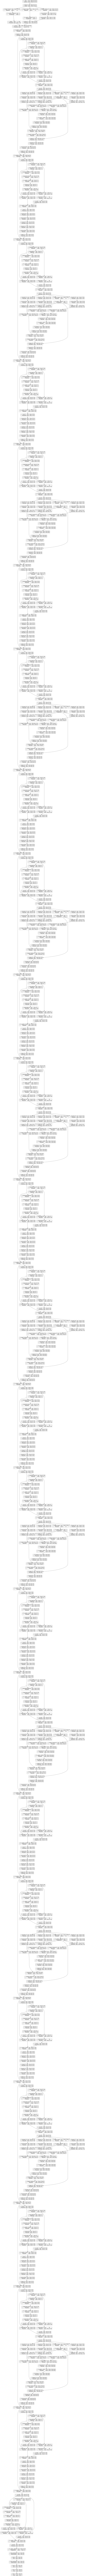

In [29]:
keras.utils.plot_model(model, show_trainable=True, show_shapes=True)

In [30]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

In [31]:

train_data_gen.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [32]:
model.fit(train_data_gen,
          validation_data=test_data_gen,
          epochs=20,
          batch_size=32,
          callbacks=[keras.callbacks.EarlyStopping(patience=5, monitor="val_accuracy", mode="auto"),
                    keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, monitor="val_accuracy", mode="max")])

Epoch 1/20
 32/795 [>.............................] - ETA: 5:25 - loss: 2.1469 - accuracy: 0.1406

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


795/795 [==============================] - 458s 559ms/step - loss: 1.7932 - accuracy: 0.2863 - val_loss: 1.6448 - val_accuracy: 0.3613 - lr: 1.0000e-04
Epoch 2/20
795/795 [==============================] - 440s 553ms/step - loss: 1.5714 - accuracy: 0.3893 - val_loss: 1.5578 - val_accuracy: 0.3973 - lr: 1.0000e-04
Epoch 3/20
795/795 [==============================] - 441s 554ms/step - loss: 1.4848 - accuracy: 0.4258 - val_loss: 1.5171 - val_accuracy: 0.4157 - lr: 1.0000e-04
Epoch 4/20
795/795 [==============================] - 440s 553ms/step - loss: 1.4204 - accuracy: 0.4530 - val_loss: 1.4961 - val_accuracy: 0.4270 - lr: 1.0000e-04
Epoch 5/20
795/795 [==============================] - 443s 557ms/step - loss: 1.3733 - accuracy: 0.4751 - val_loss: 1.4869 - val_accuracy: 0.4323 - lr: 1.0000e-04
Epoch 6/20
795/795 [==============================] - 440s 553ms/step - loss: 1.3309 - accuracy: 0.4940 - val_loss: 1.4838 - val_accuracy: 0.4326 - lr: 1.0000e-04
Epoch 7/20
795/795 [=============

<Axes: >

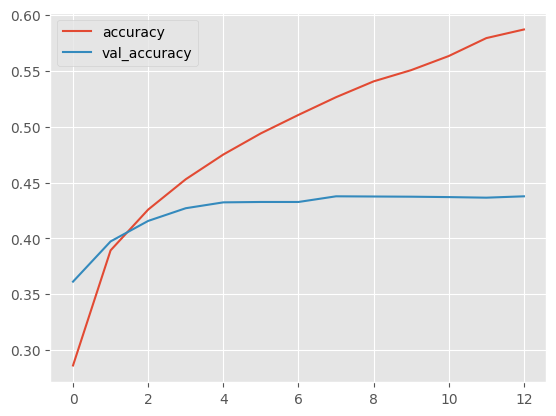

In [36]:
pd.DataFrame(model.history.history)[["accuracy", "val_accuracy"]].plot()

<Axes: >

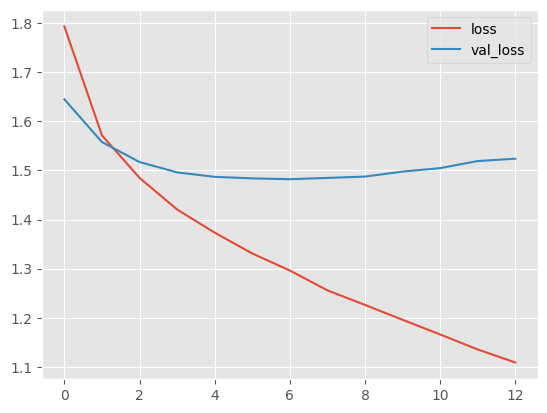

In [37]:
pd.DataFrame(model.history.history)[["loss", "val_loss"]].plot()

## Eddy